<a href="https://colab.research.google.com/github/runnithan03/Dissertation/blob/main/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna -i https://pypi.org/simple

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import optuna

np.random.seed(123)
torch.manual_seed(123)

In [ ]:
from google.colab import files
import os

uploaded = files.upload()

uploaded_filename = list(uploaded.keys())[0]
os.rename(uploaded_filename, 'clean.csv')

Saving final.csv to final.csv


In [ ]:
n_predictors = 12
n_responses = 2

response_names = ['roe', 'sustainability_score']

data = pd.read_csv('clean.csv')

categorical_columns = ['category', 'rating', 'risk_rating']

# Frequency encoding categorical columns
for col in categorical_columns:
    freq_encoding = data[col].value_counts().to_dict()
    data[col] = data[col].map(freq_encoding)

# Split dataset into features (X) and target (Y)
X = data.iloc[:, :n_predictors].values
Y = data.iloc[:, n_predictors:].values

# Normalise predictors and responses
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X = scaler_X.fit_transform(X)
Y = scaler_Y.fit_transform(Y)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_predictors, n_responses, hidden_units1=128, hidden_units2=64, dropout_rate=0.1):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_predictors, hidden_units1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units1),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_units1, hidden_units2),
            nn.ReLU(),
            nn.Linear(hidden_units2, 32),
            nn.ReLU(),
            nn.Linear(32, n_responses)
        )

    def forward(self, x):
        return self.model(x)


# Initialise model
model = NeuralNetwork(n_predictors, n_responses)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.MSELoss()

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, min_lr=1e-6)

# Early stopping (implemented manually during training)
early_stopping_patience = 15

print(model)

NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [ ]:
def calculate_nrmse(y_true, y_pred, response_names=None):
    # Calculate MSE and NRMSE
    mse = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    rsr = np.sqrt(mse) / np.std(y_true, axis=0)  # RSR for each response

    # Print RSR for each response
    if response_names:
        for i, response in enumerate(response_names):
            print(f"RSR for {response}: {rsr[i]:.4f}")

    # Return both individual RSR and the average
    return rsr, np.mean(rsr)

In [ ]:
from sklearn.model_selection import train_test_split

def objective(trial):
    # Hyperparameter tuning
    hidden_units1 = trial.suggest_int('hidden_units1', 64, 256)
    hidden_units2 = trial.suggest_int('hidden_units2', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Model definition
    model = NeuralNetwork(n_predictors, n_responses, hidden_units1, hidden_units2, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, min_lr=1e-6)
    loss_fn = nn.MSELoss()

    # Train-validation split
    X_train_split, X_val, Y_train_split, Y_val = train_test_split(
        X_train, Y_train, test_size=0.2, random_state=42
    )

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_split, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train_split, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

    # Training loop
    epochs = 100
    best_loss = np.inf
    patience_counter = 0
    early_stopping_patience = 10

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train_tensor.size(0))
        epoch_loss = 0.0

        for i in range(0, X_train_tensor.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_x, batch_y = X_train_tensor[indices], Y_train_tensor[indices]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = loss_fn(val_outputs, Y_val_tensor).item()

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                break

    # Evaluate model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val_tensor).numpy()

    # Calculate RSR for each response and ARSR
    rsr, avg_rsr = calculate_nrmse(Y_val, y_pred, response_names)

    # Report to Optuna
    trial.set_user_attr("RSR (roe)", rsr[0])
    trial.set_user_attr("RSR (sustainability_score)", rsr[1])
    trial.set_user_attr("ARSR", avg_rsr)

    print(f"ARSR: {avg_rsr:.4f}")

    return avg_rsr  # Minimize average RSR


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

# Best hyperparameters found by Optuna
print("Best trial:", study.best_trial.params)

[I 2025-01-04 20:19:23,588] A new study created in memory with name: no-name-08e37abb-e214-4190-8b6f-8b7cb7d9e4a0
<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:19:30,587] Trial 0 finished with value: 0.7250455933199602 and parameters: {'hidden_units1': 157, 'hidden_units2': 104, 'dropout_rate': 0.42871156326178583, 'lr': 0.00028327958872636773, 'batch_size': 32}. Best is trial 0 with value: 0.7250455933199602.


RSR for roe: 0.7626
RSR for sustainability_score: 0.6875
ARSR: 0.7250


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:19:32,742] Trial 1 finished with value: 0.6477778734708772 and parameters: {'hidden_units1': 177, 'hidden_units2': 91, 'dropout_rate': 0.491516870081228, 'lr': 0.0018303590615805134, 'batch_size': 128}. Best is trial 1 with value: 0.6477778734708772.


RSR for roe: 0.7405
RSR for sustainability_score: 0.5550
ARSR: 0.6478


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:19:36,240] Trial 2 finished with value: 0.6984718829192712 and parameters: {'hidden_units1': 105, 'hidden_units2': 59, 'dropout_rate': 0.3967346008788373, 'lr': 0.0005933116709348984, 'batch_size': 64}. Best is trial 1 with value: 0.6477778734708772.


RSR for roe: 0.7420
RSR for sustainability_score: 0.6550
ARSR: 0.6985


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:19:37,400] Trial 3 finished with value: 0.6540420849832163 and parameters: {'hidden_units1': 181, 'hidden_units2': 64, 'dropout_rate': 0.13853411499251062, 'lr': 0.0017217269043011195, 'batch_size': 128}. Best is trial 1 with value: 0.6477778734708772.


RSR for roe: 0.7451
RSR for sustainability_score: 0.5630
ARSR: 0.6540


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:19:39,333] Trial 4 finished with value: 0.9298589100752351 and parameters: {'hidden_units1': 186, 'hidden_units2': 86, 'dropout_rate': 0.2547972012570814, 'lr': 2.2491931140296614e-05, 'batch_size': 128}. Best is trial 1 with value: 0.6477778734708772.


RSR for roe: 0.8742
RSR for sustainability_score: 0.9856
ARSR: 0.9299


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:19:41,061] Trial 5 finished with value: 0.913980476145644 and parameters: {'hidden_units1': 149, 'hidden_units2': 68, 'dropout_rate': 0.33309963873715875, 'lr': 3.504335525852704e-05, 'batch_size': 128}. Best is trial 1 with value: 0.6477778734708772.


RSR for roe: 0.8621
RSR for sustainability_score: 0.9659
ARSR: 0.9140


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:19:46,689] Trial 6 finished with value: 0.8598507235904163 and parameters: {'hidden_units1': 151, 'hidden_units2': 40, 'dropout_rate': 0.29770032034927885, 'lr': 4.271312547140696e-05, 'batch_size': 32}. Best is trial 1 with value: 0.6477778734708772.


RSR for roe: 0.7985
RSR for sustainability_score: 0.9212
ARSR: 0.8599


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:19:50,893] Trial 7 finished with value: 0.6531500153131882 and parameters: {'hidden_units1': 225, 'hidden_units2': 48, 'dropout_rate': 0.35734971768535617, 'lr': 0.0036776282536025505, 'batch_size': 32}. Best is trial 1 with value: 0.6477778734708772.


RSR for roe: 0.7489
RSR for sustainability_score: 0.5574
ARSR: 0.6532


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:19:56,313] Trial 8 finished with value: 0.9226326622204217 and parameters: {'hidden_units1': 110, 'hidden_units2': 107, 'dropout_rate': 0.3070937431206684, 'lr': 1.2425779613048906e-05, 'batch_size': 32}. Best is trial 1 with value: 0.6477778734708772.


RSR for roe: 0.8726
RSR for sustainability_score: 0.9727
ARSR: 0.9226


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:00,561] Trial 9 finished with value: 0.7759167143744622 and parameters: {'hidden_units1': 241, 'hidden_units2': 87, 'dropout_rate': 0.228626207362076, 'lr': 0.00013299755964246238, 'batch_size': 64}. Best is trial 1 with value: 0.6477778734708772.


RSR for roe: 0.7457
RSR for sustainability_score: 0.8062
ARSR: 0.7759


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:01,448] Trial 10 finished with value: 0.7536229038361123 and parameters: {'hidden_units1': 66, 'hidden_units2': 127, 'dropout_rate': 0.49952689835367514, 'lr': 0.006675106016578328, 'batch_size': 128}. Best is trial 1 with value: 0.6477778734708772.


RSR for roe: 0.7931
RSR for sustainability_score: 0.7142
ARSR: 0.7536


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:05,274] Trial 11 finished with value: 0.6727186931909193 and parameters: {'hidden_units1': 234, 'hidden_units2': 37, 'dropout_rate': 0.49960893063885414, 'lr': 0.008296811257184943, 'batch_size': 32}. Best is trial 1 with value: 0.6477778734708772.


RSR for roe: 0.7532
RSR for sustainability_score: 0.5922
ARSR: 0.6727


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:06,393] Trial 12 finished with value: 0.6940938556855736 and parameters: {'hidden_units1': 211, 'hidden_units2': 52, 'dropout_rate': 0.4083905715872512, 'lr': 0.002062760639382726, 'batch_size': 128}. Best is trial 1 with value: 0.6477778734708772.


RSR for roe: 0.7612
RSR for sustainability_score: 0.6270
ARSR: 0.6941


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:10,588] Trial 13 finished with value: 0.6478226604285919 and parameters: {'hidden_units1': 212, 'hidden_units2': 76, 'dropout_rate': 0.37184163732810815, 'lr': 0.001596402675906545, 'batch_size': 32}. Best is trial 1 with value: 0.6477778734708772.


RSR for roe: 0.7556
RSR for sustainability_score: 0.5400
ARSR: 0.6478


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:14,288] Trial 14 finished with value: 0.6367305553984353 and parameters: {'hidden_units1': 197, 'hidden_units2': 76, 'dropout_rate': 0.45822039702452716, 'lr': 0.0008755382652919536, 'batch_size': 64}. Best is trial 14 with value: 0.6367305553984353.


RSR for roe: 0.7447
RSR for sustainability_score: 0.5287
ARSR: 0.6367


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:17,786] Trial 15 finished with value: 0.6452260145391251 and parameters: {'hidden_units1': 191, 'hidden_units2': 99, 'dropout_rate': 0.44557956390343945, 'lr': 0.0006052955254847519, 'batch_size': 64}. Best is trial 14 with value: 0.6367305553984353.


RSR for roe: 0.7283
RSR for sustainability_score: 0.5621
ARSR: 0.6452


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:20,898] Trial 16 finished with value: 0.6196388364584334 and parameters: {'hidden_units1': 194, 'hidden_units2': 103, 'dropout_rate': 0.4486831343981736, 'lr': 0.0006369528352294556, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7425
RSR for sustainability_score: 0.4968
ARSR: 0.6196


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:23,906] Trial 17 finished with value: 0.7844825545210039 and parameters: {'hidden_units1': 129, 'hidden_units2': 118, 'dropout_rate': 0.4550532181438394, 'lr': 0.0001750482387999839, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7763
RSR for sustainability_score: 0.7926
ARSR: 0.7845


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:29,006] Trial 18 finished with value: 0.6404400193258368 and parameters: {'hidden_units1': 255, 'hidden_units2': 75, 'dropout_rate': 0.12077450152962241, 'lr': 0.0005671961811289513, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7447
RSR for sustainability_score: 0.5362
ARSR: 0.6404


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:32,312] Trial 19 finished with value: 0.780504551809877 and parameters: {'hidden_units1': 208, 'hidden_units2': 114, 'dropout_rate': 0.19022717775410913, 'lr': 0.00010084605495526496, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7525
RSR for sustainability_score: 0.8086
ARSR: 0.7805


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:35,503] Trial 20 finished with value: 0.6260996597197922 and parameters: {'hidden_units1': 170, 'hidden_units2': 97, 'dropout_rate': 0.4597032077458765, 'lr': 0.0009237508452214682, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7339
RSR for sustainability_score: 0.5183
ARSR: 0.6261


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:38,611] Trial 21 finished with value: 0.6423649784025476 and parameters: {'hidden_units1': 171, 'hidden_units2': 94, 'dropout_rate': 0.45406434105873117, 'lr': 0.0009170306329740423, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7637
RSR for sustainability_score: 0.5210
ARSR: 0.6424


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:42,932] Trial 22 finished with value: 0.7123527501577578 and parameters: {'hidden_units1': 200, 'hidden_units2': 82, 'dropout_rate': 0.39625133393396106, 'lr': 0.00033791175470768007, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7494
RSR for sustainability_score: 0.6753
ARSR: 0.7124


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:45,972] Trial 23 finished with value: 0.657691668016785 and parameters: {'hidden_units1': 140, 'hidden_units2': 110, 'dropout_rate': 0.4541114003439719, 'lr': 0.0010928243537605378, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7488
RSR for sustainability_score: 0.5666
ARSR: 0.6577


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:47,367] Trial 24 finished with value: 0.6849668205275046 and parameters: {'hidden_units1': 195, 'hidden_units2': 102, 'dropout_rate': 0.4206637791187803, 'lr': 0.003415864724740173, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7619
RSR for sustainability_score: 0.6080
ARSR: 0.6850


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:50,447] Trial 25 finished with value: 0.6858103825652035 and parameters: {'hidden_units1': 170, 'hidden_units2': 96, 'dropout_rate': 0.4706888017958825, 'lr': 0.0003913618087869032, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7544
RSR for sustainability_score: 0.6173
ARSR: 0.6858


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:52,823] Trial 26 finished with value: 0.6334839496257563 and parameters: {'hidden_units1': 223, 'hidden_units2': 122, 'dropout_rate': 0.37142987386216786, 'lr': 0.003535200762319122, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7334
RSR for sustainability_score: 0.5336
ARSR: 0.6335


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:55,095] Trial 27 finished with value: 0.7103599760759501 and parameters: {'hidden_units1': 220, 'hidden_units2': 125, 'dropout_rate': 0.37852990652484375, 'lr': 0.004027629220276609, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7518
RSR for sustainability_score: 0.6689
ARSR: 0.7104


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:20:57,411] Trial 28 finished with value: 0.6630493511475756 and parameters: {'hidden_units1': 249, 'hidden_units2': 114, 'dropout_rate': 0.3295896188982674, 'lr': 0.00487376158493932, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.8040
RSR for sustainability_score: 0.5221
ARSR: 0.6630


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:00,843] Trial 29 finished with value: 0.7477568947961689 and parameters: {'hidden_units1': 231, 'hidden_units2': 121, 'dropout_rate': 0.42845627446210766, 'lr': 0.00020526880000079715, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7570
RSR for sustainability_score: 0.7385
ARSR: 0.7478


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:02,585] Trial 30 finished with value: 0.6422736234389352 and parameters: {'hidden_units1': 164, 'hidden_units2': 104, 'dropout_rate': 0.3498319394439703, 'lr': 0.002639900168948161, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7591
RSR for sustainability_score: 0.5254
ARSR: 0.6423


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:05,379] Trial 31 finished with value: 0.6420505250043993 and parameters: {'hidden_units1': 199, 'hidden_units2': 72, 'dropout_rate': 0.47152529359550893, 'lr': 0.0010114606625939505, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7366
RSR for sustainability_score: 0.5475
ARSR: 0.6421


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:09,618] Trial 32 finished with value: 0.6580585060443496 and parameters: {'hidden_units1': 181, 'hidden_units2': 91, 'dropout_rate': 0.4308716523214274, 'lr': 0.0011965154388982348, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7652
RSR for sustainability_score: 0.5509
ARSR: 0.6581


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:12,753] Trial 33 finished with value: 0.6931075888062139 and parameters: {'hidden_units1': 218, 'hidden_units2': 83, 'dropout_rate': 0.3893308375470937, 'lr': 0.00045268361604315746, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7530
RSR for sustainability_score: 0.6332
ARSR: 0.6931


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:15,819] Trial 34 finished with value: 0.6524670070412937 and parameters: {'hidden_units1': 159, 'hidden_units2': 110, 'dropout_rate': 0.4713411647904125, 'lr': 0.0007660859843870458, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7620
RSR for sustainability_score: 0.5429
ARSR: 0.6525


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:18,910] Trial 35 finished with value: 0.76410620004738 and parameters: {'hidden_units1': 180, 'hidden_units2': 90, 'dropout_rate': 0.4433813600247756, 'lr': 0.00023769979186007045, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7737
RSR for sustainability_score: 0.7545
ARSR: 0.7641


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:21,379] Trial 36 finished with value: 0.6585311410204329 and parameters: {'hidden_units1': 203, 'hidden_units2': 65, 'dropout_rate': 0.41249197471963384, 'lr': 0.0015858193691530864, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7581
RSR for sustainability_score: 0.5589
ARSR: 0.6585


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:23,871] Trial 37 finished with value: 0.6569391350599729 and parameters: {'hidden_units1': 192, 'hidden_units2': 99, 'dropout_rate': 0.4807730885314405, 'lr': 0.0024816404940613446, 'batch_size': 128}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7529
RSR for sustainability_score: 0.5609
ARSR: 0.6569


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:26,823] Trial 38 finished with value: 0.8321060610715362 and parameters: {'hidden_units1': 147, 'hidden_units2': 79, 'dropout_rate': 0.2787596078309512, 'lr': 8.410742135591506e-05, 'batch_size': 64}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7917
RSR for sustainability_score: 0.8726
ARSR: 0.8321


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:30,694] Trial 39 finished with value: 0.6471403533171157 and parameters: {'hidden_units1': 123, 'hidden_units2': 118, 'dropout_rate': 0.36441148005379237, 'lr': 0.000675833336601157, 'batch_size': 32}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.7413
RSR for sustainability_score: 0.5530
ARSR: 0.6471


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:32,481] Trial 40 finished with value: 0.6838059972713677 and parameters: {'hidden_units1': 239, 'hidden_units2': 58, 'dropout_rate': 0.32213639775515523, 'lr': 0.0013461802704205124, 'batch_size': 128}. Best is trial 16 with value: 0.6196388364584334.


RSR for roe: 0.8020
RSR for sustainability_score: 0.5656
ARSR: 0.6838


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:36,923] Trial 41 finished with value: 0.6090535057618737 and parameters: {'hidden_units1': 254, 'hidden_units2': 75, 'dropout_rate': 0.10383577415946255, 'lr': 0.0005931226400552811, 'batch_size': 64}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7248
RSR for sustainability_score: 0.4933
ARSR: 0.6091


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:40,096] Trial 42 finished with value: 0.6672362330384988 and parameters: {'hidden_units1': 227, 'hidden_units2': 86, 'dropout_rate': 0.1893891354403951, 'lr': 0.0004346313679341278, 'batch_size': 64}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7617
RSR for sustainability_score: 0.5727
ARSR: 0.6672


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:43,251] Trial 43 finished with value: 0.6849805792391778 and parameters: {'hidden_units1': 243, 'hidden_units2': 71, 'dropout_rate': 0.14972846529236647, 'lr': 0.0002904398345781848, 'batch_size': 64}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7292
RSR for sustainability_score: 0.6407
ARSR: 0.6850


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:46,172] Trial 44 finished with value: 0.6111891524397521 and parameters: {'hidden_units1': 219, 'hidden_units2': 61, 'dropout_rate': 0.10113398813726639, 'lr': 0.0008297350410036145, 'batch_size': 64}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7376
RSR for sustainability_score: 0.4847
ARSR: 0.6112


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:48,642] Trial 45 finished with value: 0.7353239706209301 and parameters: {'hidden_units1': 220, 'hidden_units2': 60, 'dropout_rate': 0.11613426545725919, 'lr': 0.006145724336556131, 'batch_size': 64}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7698
RSR for sustainability_score: 0.7009
ARSR: 0.7353


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:51,393] Trial 46 finished with value: 0.6745905918831983 and parameters: {'hidden_units1': 69, 'hidden_units2': 50, 'dropout_rate': 0.16298890893585744, 'lr': 0.002300987623366311, 'batch_size': 32}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7602
RSR for sustainability_score: 0.5890
ARSR: 0.6746


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:54,518] Trial 47 finished with value: 0.6565998889853097 and parameters: {'hidden_units1': 250, 'hidden_units2': 57, 'dropout_rate': 0.10813593996801156, 'lr': 0.00047313525058641226, 'batch_size': 64}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7245
RSR for sustainability_score: 0.5887
ARSR: 0.6566


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:56,282] Trial 48 finished with value: 0.6253577303210647 and parameters: {'hidden_units1': 234, 'hidden_units2': 66, 'dropout_rate': 0.25186030505439594, 'lr': 0.0017657710894866132, 'batch_size': 128}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7497
RSR for sustainability_score: 0.5010
ARSR: 0.6254


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:21:58,342] Trial 49 finished with value: 0.658174334440331 and parameters: {'hidden_units1': 255, 'hidden_units2': 65, 'dropout_rate': 0.24337850994117463, 'lr': 0.0015349057436250945, 'batch_size': 128}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7728
RSR for sustainability_score: 0.5436
ARSR: 0.6582


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:00,157] Trial 50 finished with value: 0.68269416317101 and parameters: {'hidden_units1': 233, 'hidden_units2': 41, 'dropout_rate': 0.20934256146582275, 'lr': 0.0007096692135215092, 'batch_size': 128}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7549
RSR for sustainability_score: 0.6105
ARSR: 0.6827


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:01,672] Trial 51 finished with value: 0.662342166799725 and parameters: {'hidden_units1': 240, 'hidden_units2': 68, 'dropout_rate': 0.12961428985156404, 'lr': 0.0031105673643450895, 'batch_size': 128}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7740
RSR for sustainability_score: 0.5507
ARSR: 0.6623


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:02,833] Trial 52 finished with value: 0.7086064875469951 and parameters: {'hidden_units1': 209, 'hidden_units2': 69, 'dropout_rate': 0.10081075088370908, 'lr': 0.009905927888770935, 'batch_size': 128}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.8068
RSR for sustainability_score: 0.6104
ARSR: 0.7086


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:04,834] Trial 53 finished with value: 0.7417850635013843 and parameters: {'hidden_units1': 187, 'hidden_units2': 54, 'dropout_rate': 0.28675285478458656, 'lr': 0.0005623389507990657, 'batch_size': 128}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7751
RSR for sustainability_score: 0.7085
ARSR: 0.7418


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:10,142] Trial 54 finished with value: 0.6236486304370468 and parameters: {'hidden_units1': 216, 'hidden_units2': 61, 'dropout_rate': 0.16521363160182695, 'lr': 0.0009123209057876477, 'batch_size': 32}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7264
RSR for sustainability_score: 0.5209
ARSR: 0.6236


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:13,619] Trial 55 finished with value: 0.6326386558408886 and parameters: {'hidden_units1': 216, 'hidden_units2': 62, 'dropout_rate': 0.16214276594610338, 'lr': 0.001932798956469335, 'batch_size': 32}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7772
RSR for sustainability_score: 0.4881
ARSR: 0.6326


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:17,357] Trial 56 finished with value: 0.665174513289112 and parameters: {'hidden_units1': 205, 'hidden_units2': 45, 'dropout_rate': 0.14004907687884324, 'lr': 0.001314170664489894, 'batch_size': 32}. Best is trial 41 with value: 0.6090535057618737.


RSR for roe: 0.7491
RSR for sustainability_score: 0.5812
ARSR: 0.6652


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:22,442] Trial 57 finished with value: 0.6066166612189993 and parameters: {'hidden_units1': 175, 'hidden_units2': 73, 'dropout_rate': 0.2650463259421376, 'lr': 0.0008698351036376007, 'batch_size': 32}. Best is trial 57 with value: 0.6066166612189993.


RSR for roe: 0.7366
RSR for sustainability_score: 0.4766
ARSR: 0.6066


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:28,386] Trial 58 finished with value: 0.6650820905901298 and parameters: {'hidden_units1': 228, 'hidden_units2': 74, 'dropout_rate': 0.26740326450685836, 'lr': 0.00033644156579524755, 'batch_size': 32}. Best is trial 57 with value: 0.6066166612189993.


RSR for roe: 0.7334
RSR for sustainability_score: 0.5968
ARSR: 0.6651


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:34,591] Trial 59 finished with value: 0.6144956163157183 and parameters: {'hidden_units1': 248, 'hidden_units2': 78, 'dropout_rate': 0.24324035922460033, 'lr': 0.0008706641076303445, 'batch_size': 32}. Best is trial 57 with value: 0.6066166612189993.


RSR for roe: 0.7169
RSR for sustainability_score: 0.5121
ARSR: 0.6145


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:39,825] Trial 60 finished with value: 0.6381074826108879 and parameters: {'hidden_units1': 246, 'hidden_units2': 79, 'dropout_rate': 0.22951347099590041, 'lr': 0.0008242985608275099, 'batch_size': 32}. Best is trial 57 with value: 0.6066166612189993.


RSR for roe: 0.7530
RSR for sustainability_score: 0.5232
ARSR: 0.6381


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:46,063] Trial 61 finished with value: 0.6416861001750411 and parameters: {'hidden_units1': 236, 'hidden_units2': 67, 'dropout_rate': 0.2530893463105405, 'lr': 0.0005549887534023956, 'batch_size': 32}. Best is trial 57 with value: 0.6066166612189993.


RSR for roe: 0.7356
RSR for sustainability_score: 0.5478
ARSR: 0.6417


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:50,094] Trial 62 finished with value: 0.625681791553331 and parameters: {'hidden_units1': 254, 'hidden_units2': 54, 'dropout_rate': 0.19200362785153394, 'lr': 0.001040310757234737, 'batch_size': 32}. Best is trial 57 with value: 0.6066166612189993.


RSR for roe: 0.7215
RSR for sustainability_score: 0.5298
ARSR: 0.6257


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:54,337] Trial 63 finished with value: 0.6028880240592814 and parameters: {'hidden_units1': 213, 'hidden_units2': 63, 'dropout_rate': 0.23672607202923537, 'lr': 0.0018604608413098122, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7236
RSR for sustainability_score: 0.4822
ARSR: 0.6029


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:22:59,853] Trial 64 finished with value: 0.6274537174556182 and parameters: {'hidden_units1': 188, 'hidden_units2': 62, 'dropout_rate': 0.21341288398768266, 'lr': 0.0007795813287236238, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7544
RSR for sustainability_score: 0.5005
ARSR: 0.6275


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:23:03,551] Trial 65 finished with value: 0.6549465727613555 and parameters: {'hidden_units1': 173, 'hidden_units2': 76, 'dropout_rate': 0.29737993540967145, 'lr': 0.0011936021858870824, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7527
RSR for sustainability_score: 0.5572
ARSR: 0.6549


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:23:09,599] Trial 66 finished with value: 0.6188866593864469 and parameters: {'hidden_units1': 215, 'hidden_units2': 71, 'dropout_rate': 0.173852554912441, 'lr': 0.0006145633105018534, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7184
RSR for sustainability_score: 0.5194
ARSR: 0.6189


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:23:15,589] Trial 67 finished with value: 0.6356892714741085 and parameters: {'hidden_units1': 212, 'hidden_units2': 83, 'dropout_rate': 0.23307611911305764, 'lr': 0.0005371811493524437, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7292
RSR for sustainability_score: 0.5422
ARSR: 0.6357


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:23:20,805] Trial 68 finished with value: 0.6549119221920425 and parameters: {'hidden_units1': 200, 'hidden_units2': 71, 'dropout_rate': 0.1787331414322545, 'lr': 0.00036911571317266545, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7649
RSR for sustainability_score: 0.5449
ARSR: 0.6549


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:23:27,506] Trial 69 finished with value: 0.7175310445189125 and parameters: {'hidden_units1': 223, 'hidden_units2': 87, 'dropout_rate': 0.2680052605293673, 'lr': 0.00024478583598697053, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7682
RSR for sustainability_score: 0.6669
ARSR: 0.7175


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:23:31,774] Trial 70 finished with value: 0.7793522711647369 and parameters: {'hidden_units1': 180, 'hidden_units2': 78, 'dropout_rate': 0.20748276501493623, 'lr': 0.00018619776634267316, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7794
RSR for sustainability_score: 0.7793
ARSR: 0.7794


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:23:35,634] Trial 71 finished with value: 0.6481332577484682 and parameters: {'hidden_units1': 212, 'hidden_units2': 62, 'dropout_rate': 0.1339013667973742, 'lr': 0.0008977642088577368, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7448
RSR for sustainability_score: 0.5514
ARSR: 0.6481


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:23:41,884] Trial 72 finished with value: 0.9031645154637669 and parameters: {'hidden_units1': 215, 'hidden_units2': 74, 'dropout_rate': 0.1542507553410227, 'lr': 1.1991356565525941e-05, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.8472
RSR for sustainability_score: 0.9591
ARSR: 0.9032


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:23:47,254] Trial 73 finished with value: 0.6312171663339747 and parameters: {'hidden_units1': 196, 'hidden_units2': 69, 'dropout_rate': 0.12096441291935937, 'lr': 0.0006687499618812331, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7352
RSR for sustainability_score: 0.5273
ARSR: 0.6312


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:23:53,824] Trial 74 finished with value: 0.887157151142234 and parameters: {'hidden_units1': 203, 'hidden_units2': 81, 'dropout_rate': 0.17579740732756843, 'lr': 1.8375682045084997e-05, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.8122
RSR for sustainability_score: 0.9621
ARSR: 0.8872


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:23:56,716] Trial 75 finished with value: 0.6515860482984696 and parameters: {'hidden_units1': 165, 'hidden_units2': 59, 'dropout_rate': 0.24038270164322084, 'lr': 0.0013980135829711976, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7663
RSR for sustainability_score: 0.5368
ARSR: 0.6516


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:23:59,526] Trial 76 finished with value: 0.682571365500574 and parameters: {'hidden_units1': 228, 'hidden_units2': 72, 'dropout_rate': 0.2662784143157295, 'lr': 0.001080766254302044, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7675
RSR for sustainability_score: 0.5977
ARSR: 0.6826


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:05,886] Trial 77 finished with value: 0.6419743831545803 and parameters: {'hidden_units1': 192, 'hidden_units2': 63, 'dropout_rate': 0.22034803830446129, 'lr': 0.0005143336932473563, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7425
RSR for sustainability_score: 0.5414
ARSR: 0.6420


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:10,934] Trial 78 finished with value: 0.6784680911820076 and parameters: {'hidden_units1': 208, 'hidden_units2': 33, 'dropout_rate': 0.3111517295389554, 'lr': 0.000407538887878794, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7467
RSR for sustainability_score: 0.6103
ARSR: 0.6785


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:15,223] Trial 79 finished with value: 0.6380214247012805 and parameters: {'hidden_units1': 247, 'hidden_units2': 46, 'dropout_rate': 0.10198906450384078, 'lr': 0.0006643995679037294, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7406
RSR for sustainability_score: 0.5355
ARSR: 0.6380


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:18,990] Trial 80 finished with value: 0.6500970941458721 and parameters: {'hidden_units1': 223, 'hidden_units2': 56, 'dropout_rate': 0.19424116965581356, 'lr': 0.0021927225822780992, 'batch_size': 32}. Best is trial 63 with value: 0.6028880240592814.


RSR for roe: 0.7464
RSR for sustainability_score: 0.5537
ARSR: 0.6501


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:20,945] Trial 81 finished with value: 0.6018680877002899 and parameters: {'hidden_units1': 235, 'hidden_units2': 65, 'dropout_rate': 0.2545420843054248, 'lr': 0.0018290263484599379, 'batch_size': 128}. Best is trial 81 with value: 0.6018680877002899.


RSR for roe: 0.7222
RSR for sustainability_score: 0.4815
ARSR: 0.6019


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:24,029] Trial 82 finished with value: 0.6133397653172893 and parameters: {'hidden_units1': 243, 'hidden_units2': 70, 'dropout_rate': 0.2867426745029044, 'lr': 0.0008594092794920842, 'batch_size': 64}. Best is trial 81 with value: 0.6018680877002899.


RSR for roe: 0.7231
RSR for sustainability_score: 0.5036
ARSR: 0.6133


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:25,823] Trial 83 finished with value: 0.6172705153764356 and parameters: {'hidden_units1': 243, 'hidden_units2': 73, 'dropout_rate': 0.2789775305857568, 'lr': 0.0017474279685433176, 'batch_size': 64}. Best is trial 81 with value: 0.6018680877002899.


RSR for roe: 0.7349
RSR for sustainability_score: 0.4996
ARSR: 0.6173


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:27,906] Trial 84 finished with value: 0.6177082681765835 and parameters: {'hidden_units1': 243, 'hidden_units2': 77, 'dropout_rate': 0.28372750954326953, 'lr': 0.00274907978071508, 'batch_size': 64}. Best is trial 81 with value: 0.6018680877002899.


RSR for roe: 0.7692
RSR for sustainability_score: 0.4662
ARSR: 0.6177


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:30,346] Trial 85 finished with value: 0.6231123260347151 and parameters: {'hidden_units1': 243, 'hidden_units2': 77, 'dropout_rate': 0.2802966677162169, 'lr': 0.002915722436519246, 'batch_size': 64}. Best is trial 81 with value: 0.6018680877002899.


RSR for roe: 0.7512
RSR for sustainability_score: 0.4950
ARSR: 0.6231


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:32,951] Trial 86 finished with value: 0.6126679086215565 and parameters: {'hidden_units1': 250, 'hidden_units2': 85, 'dropout_rate': 0.30220737726890756, 'lr': 0.004561448159047666, 'batch_size': 64}. Best is trial 81 with value: 0.6018680877002899.


RSR for roe: 0.7490
RSR for sustainability_score: 0.4764
ARSR: 0.6127


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:35,165] Trial 87 finished with value: 0.6207994657164755 and parameters: {'hidden_units1': 252, 'hidden_units2': 83, 'dropout_rate': 0.29979737338303003, 'lr': 0.0019214266010754268, 'batch_size': 64}. Best is trial 81 with value: 0.6018680877002899.


RSR for roe: 0.7264
RSR for sustainability_score: 0.5152
ARSR: 0.6208


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:36,442] Trial 88 finished with value: 0.8324054255365005 and parameters: {'hidden_units1': 238, 'hidden_units2': 86, 'dropout_rate': 0.3104300582827221, 'lr': 0.005909236545977387, 'batch_size': 64}. Best is trial 81 with value: 0.6018680877002899.


RSR for roe: 0.7681
RSR for sustainability_score: 0.8968
ARSR: 0.8324


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:38,238] Trial 89 finished with value: 0.6158544738265411 and parameters: {'hidden_units1': 247, 'hidden_units2': 74, 'dropout_rate': 0.343624546744147, 'lr': 0.004850254345593454, 'batch_size': 64}. Best is trial 81 with value: 0.6018680877002899.


RSR for roe: 0.7682
RSR for sustainability_score: 0.4635
ARSR: 0.6159


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:40,368] Trial 90 finished with value: 0.6057717863776446 and parameters: {'hidden_units1': 256, 'hidden_units2': 89, 'dropout_rate': 0.33257230832293816, 'lr': 0.00421658744873636, 'batch_size': 64}. Best is trial 81 with value: 0.6018680877002899.


RSR for roe: 0.7386
RSR for sustainability_score: 0.4730
ARSR: 0.6058


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:41,202] Trial 91 finished with value: 0.7373013879319562 and parameters: {'hidden_units1': 250, 'hidden_units2': 92, 'dropout_rate': 0.341953554142863, 'lr': 0.004491801340141252, 'batch_size': 64}. Best is trial 81 with value: 0.6018680877002899.


RSR for roe: 0.7365
RSR for sustainability_score: 0.7381
ARSR: 0.7373


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:43,408] Trial 92 finished with value: 0.6670514895844318 and parameters: {'hidden_units1': 255, 'hidden_units2': 89, 'dropout_rate': 0.32601277840335424, 'lr': 0.003894485861540884, 'batch_size': 64}. Best is trial 81 with value: 0.6018680877002899.


RSR for roe: 0.7226
RSR for sustainability_score: 0.6115
ARSR: 0.6671


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:45,044] Trial 93 finished with value: 0.7469268617109011 and parameters: {'hidden_units1': 246, 'hidden_units2': 80, 'dropout_rate': 0.34143363441889096, 'lr': 0.00785936172131846, 'batch_size': 64}. Best is trial 81 with value: 0.6018680877002899.


RSR for roe: 0.7751
RSR for sustainability_score: 0.7188
ARSR: 0.7469


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:47,810] Trial 94 finished with value: 0.5652099983080655 and parameters: {'hidden_units1': 233, 'hidden_units2': 65, 'dropout_rate': 0.31777562686628213, 'lr': 0.004933608379620676, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7394
RSR for sustainability_score: 0.3910
ARSR: 0.5652


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:49,247] Trial 95 finished with value: 0.6829964724565142 and parameters: {'hidden_units1': 231, 'hidden_units2': 64, 'dropout_rate': 0.31675598879903705, 'lr': 0.005562892661861534, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7739
RSR for sustainability_score: 0.5921
ARSR: 0.6830


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:50,162] Trial 96 finished with value: 0.7129392997933004 and parameters: {'hidden_units1': 236, 'hidden_units2': 67, 'dropout_rate': 0.29581475585225925, 'lr': 0.007726149448072289, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7516
RSR for sustainability_score: 0.6743
ARSR: 0.7129


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:51,430] Trial 97 finished with value: 0.6338968466538781 and parameters: {'hidden_units1': 239, 'hidden_units2': 69, 'dropout_rate': 0.26953602330511683, 'lr': 0.0034671293969856212, 'batch_size': 128}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7648
RSR for sustainability_score: 0.5030
ARSR: 0.6339


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:52,416] Trial 98 finished with value: 0.7041107459447558 and parameters: {'hidden_units1': 230, 'hidden_units2': 95, 'dropout_rate': 0.2585570522481809, 'lr': 0.006843650935469278, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7518
RSR for sustainability_score: 0.6564
ARSR: 0.7041


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:54,819] Trial 99 finished with value: 0.6455398996832721 and parameters: {'hidden_units1': 250, 'hidden_units2': 84, 'dropout_rate': 0.3572531830123242, 'lr': 0.0023274622778476557, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7467
RSR for sustainability_score: 0.5444
ARSR: 0.6455


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:24:57,368] Trial 100 finished with value: 0.6453363652869879 and parameters: {'hidden_units1': 255, 'hidden_units2': 65, 'dropout_rate': 0.243755015447718, 'lr': 0.001568947052149315, 'batch_size': 128}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7737
RSR for sustainability_score: 0.5169
ARSR: 0.6453


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:00,598] Trial 101 finished with value: 0.64903000526409 and parameters: {'hidden_units1': 247, 'hidden_units2': 75, 'dropout_rate': 0.317704632689618, 'lr': 0.004697223149708229, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7567
RSR for sustainability_score: 0.5414
ARSR: 0.6490


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:02,791] Trial 102 finished with value: 0.6461112452656649 and parameters: {'hidden_units1': 154, 'hidden_units2': 69, 'dropout_rate': 0.3330023542359304, 'lr': 0.005131647892588786, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7987
RSR for sustainability_score: 0.4936
ARSR: 0.6461


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:04,750] Trial 103 finished with value: 0.6434392666288974 and parameters: {'hidden_units1': 234, 'hidden_units2': 81, 'dropout_rate': 0.2914900762103234, 'lr': 0.004094694082270953, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7474
RSR for sustainability_score: 0.5395
ARSR: 0.6434


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:06,034] Trial 104 finished with value: 0.6291828798670236 and parameters: {'hidden_units1': 251, 'hidden_units2': 60, 'dropout_rate': 0.30447472298634226, 'lr': 0.0032506493313990033, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7694
RSR for sustainability_score: 0.4889
ARSR: 0.6292


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:08,208] Trial 105 finished with value: 0.6361507028555202 and parameters: {'hidden_units1': 256, 'hidden_units2': 55, 'dropout_rate': 0.3400632913149541, 'lr': 0.001213562081884969, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7391
RSR for sustainability_score: 0.5332
ARSR: 0.6362


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:11,661] Trial 106 finished with value: 0.6048935274959317 and parameters: {'hidden_units1': 240, 'hidden_units2': 70, 'dropout_rate': 0.25914466297928657, 'lr': 0.004342505606599478, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7313
RSR for sustainability_score: 0.4785
ARSR: 0.6049


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:14,979] Trial 107 finished with value: 0.6374821651523597 and parameters: {'hidden_units1': 226, 'hidden_units2': 85, 'dropout_rate': 0.26064812614978283, 'lr': 0.0007676456169780167, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7134
RSR for sustainability_score: 0.5616
ARSR: 0.6375


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:15,950] Trial 108 finished with value: 0.6137212702510378 and parameters: {'hidden_units1': 79, 'hidden_units2': 71, 'dropout_rate': 0.2732253094854735, 'lr': 0.009791283238989005, 'batch_size': 128}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7536
RSR for sustainability_score: 0.4739
ARSR: 0.6137


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:16,518] Trial 109 finished with value: 0.6919324551023196 and parameters: {'hidden_units1': 87, 'hidden_units2': 51, 'dropout_rate': 0.27551974027375026, 'lr': 0.008752169628652369, 'batch_size': 128}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7526
RSR for sustainability_score: 0.6313
ARSR: 0.6919


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:17,038] Trial 110 finished with value: 0.7521708788086294 and parameters: {'hidden_units1': 139, 'hidden_units2': 67, 'dropout_rate': 0.2914796082297149, 'lr': 0.009606122311220966, 'batch_size': 128}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.8109
RSR for sustainability_score: 0.6935
ARSR: 0.7522


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:17,707] Trial 111 finished with value: 0.7122442684743343 and parameters: {'hidden_units1': 241, 'hidden_units2': 71, 'dropout_rate': 0.2528667848074886, 'lr': 0.00680375620688127, 'batch_size': 128}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7836
RSR for sustainability_score: 0.6409
ARSR: 0.7122


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:19,392] Trial 112 finished with value: 0.6531973360066168 and parameters: {'hidden_units1': 114, 'hidden_units2': 64, 'dropout_rate': 0.24342086543278096, 'lr': 0.0009488445976036356, 'batch_size': 128}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7646
RSR for sustainability_score: 0.5418
ARSR: 0.6532


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:21,533] Trial 113 finished with value: 0.6078080444000167 and parameters: {'hidden_units1': 90, 'hidden_units2': 70, 'dropout_rate': 0.26140043015264164, 'lr': 0.004241496061006013, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7965
RSR for sustainability_score: 0.4191
ARSR: 0.6078


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:24,060] Trial 114 finished with value: 0.6134655477824303 and parameters: {'hidden_units1': 80, 'hidden_units2': 69, 'dropout_rate': 0.3059592530133528, 'lr': 0.004392008804707864, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7386
RSR for sustainability_score: 0.4884
ARSR: 0.6135


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:26,131] Trial 115 finished with value: 0.6747155833768084 and parameters: {'hidden_units1': 90, 'hidden_units2': 58, 'dropout_rate': 0.3047720576314046, 'lr': 0.0041090483480377225, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7550
RSR for sustainability_score: 0.5944
ARSR: 0.6747


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:28,175] Trial 116 finished with value: 0.6400018144272159 and parameters: {'hidden_units1': 219, 'hidden_units2': 66, 'dropout_rate': 0.2889013862884336, 'lr': 0.003635067508356306, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7572
RSR for sustainability_score: 0.5228
ARSR: 0.6400


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:30,013] Trial 117 finished with value: 0.6102782771640275 and parameters: {'hidden_units1': 76, 'hidden_units2': 68, 'dropout_rate': 0.3216714782391237, 'lr': 0.0026985867703148013, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7171
RSR for sustainability_score: 0.5035
ARSR: 0.6103


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:32,311] Trial 118 finished with value: 0.6199779393194061 and parameters: {'hidden_units1': 64, 'hidden_units2': 62, 'dropout_rate': 0.1150460975971662, 'lr': 0.0029008389753066993, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7696
RSR for sustainability_score: 0.4703
ARSR: 0.6200


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:33,931] Trial 119 finished with value: 0.6465364908482123 and parameters: {'hidden_units1': 70, 'hidden_units2': 75, 'dropout_rate': 0.31683870879779363, 'lr': 0.0025227168041437272, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7865
RSR for sustainability_score: 0.5066
ARSR: 0.6465


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:35,581] Trial 120 finished with value: 0.6510599235890302 and parameters: {'hidden_units1': 237, 'hidden_units2': 89, 'dropout_rate': 0.22226808645724758, 'lr': 0.005465153385442904, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7710
RSR for sustainability_score: 0.5311
ARSR: 0.6511


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:37,854] Trial 121 finished with value: 0.6191490381063789 and parameters: {'hidden_units1': 85, 'hidden_units2': 69, 'dropout_rate': 0.3290845558795867, 'lr': 0.004408242158299638, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7383
RSR for sustainability_score: 0.5000
ARSR: 0.6191


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:40,932] Trial 122 finished with value: 0.6181086414670794 and parameters: {'hidden_units1': 102, 'hidden_units2': 73, 'dropout_rate': 0.2608004849493738, 'lr': 0.0021033355733637753, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7836
RSR for sustainability_score: 0.4526
ARSR: 0.6181


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:42,780] Trial 123 finished with value: 0.6437413690171172 and parameters: {'hidden_units1': 76, 'hidden_units2': 67, 'dropout_rate': 0.32390763071142586, 'lr': 0.0031150205502808925, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7275
RSR for sustainability_score: 0.5600
ARSR: 0.6437


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:44,396] Trial 124 finished with value: 0.7015360213796601 and parameters: {'hidden_units1': 101, 'hidden_units2': 64, 'dropout_rate': 0.35201903643233956, 'lr': 0.006555057809138567, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7634
RSR for sustainability_score: 0.6397
ARSR: 0.7015


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:46,665] Trial 125 finished with value: 0.635421258958625 and parameters: {'hidden_units1': 78, 'hidden_units2': 60, 'dropout_rate': 0.30705870586457623, 'lr': 0.003559753742255954, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7666
RSR for sustainability_score: 0.5042
ARSR: 0.6354


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:49,084] Trial 126 finished with value: 0.6238279072415754 and parameters: {'hidden_units1': 73, 'hidden_units2': 69, 'dropout_rate': 0.28484061023403207, 'lr': 0.0026343265153480513, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7613
RSR for sustainability_score: 0.4863
ARSR: 0.6238


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:51,998] Trial 127 finished with value: 0.652239679868341 and parameters: {'hidden_units1': 243, 'hidden_units2': 72, 'dropout_rate': 0.37306432994326594, 'lr': 0.0014729299840546867, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7446
RSR for sustainability_score: 0.5599
ARSR: 0.6522


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:54,569] Trial 128 finished with value: 0.6308733789997366 and parameters: {'hidden_units1': 93, 'hidden_units2': 66, 'dropout_rate': 0.23678727612456268, 'lr': 0.005175715249472995, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7319
RSR for sustainability_score: 0.5298
ARSR: 0.6309


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:57,451] Trial 129 finished with value: 0.8575175222029499 and parameters: {'hidden_units1': 144, 'hidden_units2': 76, 'dropout_rate': 0.25073449779570844, 'lr': 5.367677300299042e-05, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.8077
RSR for sustainability_score: 0.9073
ARSR: 0.8575


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:25:59,351] Trial 130 finished with value: 0.6216048748910925 and parameters: {'hidden_units1': 233, 'hidden_units2': 70, 'dropout_rate': 0.29920838891723145, 'lr': 0.00401575331682644, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7749
RSR for sustainability_score: 0.4683
ARSR: 0.6216


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:00,666] Trial 131 finished with value: 0.6106672270287063 and parameters: {'hidden_units1': 84, 'hidden_units2': 71, 'dropout_rate': 0.2732864990714644, 'lr': 0.005920136171302061, 'batch_size': 128}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7246
RSR for sustainability_score: 0.4968
ARSR: 0.6107


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:01,717] Trial 132 finished with value: 0.6945248499609469 and parameters: {'hidden_units1': 80, 'hidden_units2': 73, 'dropout_rate': 0.2638590306523969, 'lr': 0.006361321689620181, 'batch_size': 128}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7424
RSR for sustainability_score: 0.6467
ARSR: 0.6945


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:04,167] Trial 133 finished with value: 0.5864901066714907 and parameters: {'hidden_units1': 87, 'hidden_units2': 63, 'dropout_rate': 0.2820620213747855, 'lr': 0.00475918969000734, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7330
RSR for sustainability_score: 0.4400
ARSR: 0.5865


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:05,834] Trial 134 finished with value: 0.6721737889828006 and parameters: {'hidden_units1': 85, 'hidden_units2': 62, 'dropout_rate': 0.2717599402932772, 'lr': 0.00574895582455983, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7369
RSR for sustainability_score: 0.6074
ARSR: 0.6722


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:07,992] Trial 135 finished with value: 0.6318070073350583 and parameters: {'hidden_units1': 94, 'hidden_units2': 58, 'dropout_rate': 0.28239284937777503, 'lr': 0.007184976428498818, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7537
RSR for sustainability_score: 0.5099
ARSR: 0.6318


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:08,787] Trial 136 finished with value: 0.7717597358239652 and parameters: {'hidden_units1': 224, 'hidden_units2': 65, 'dropout_rate': 0.24988255576440888, 'lr': 0.004900980295654322, 'batch_size': 128}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7469
RSR for sustainability_score: 0.7966
ARSR: 0.7718


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:09,932] Trial 137 finished with value: 0.6936195285783843 and parameters: {'hidden_units1': 96, 'hidden_units2': 79, 'dropout_rate': 0.27666089014294004, 'lr': 0.0032799101611346716, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7904
RSR for sustainability_score: 0.5969
ARSR: 0.6936


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:12,758] Trial 138 finished with value: 0.6123792779318269 and parameters: {'hidden_units1': 114, 'hidden_units2': 63, 'dropout_rate': 0.2949285012700447, 'lr': 0.001898816723597502, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7336
RSR for sustainability_score: 0.4912
ARSR: 0.6124


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:15,368] Trial 139 finished with value: 0.6245361880938995 and parameters: {'hidden_units1': 106, 'hidden_units2': 60, 'dropout_rate': 0.3139803144632655, 'lr': 0.0017369942701244828, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7498
RSR for sustainability_score: 0.4993
ARSR: 0.6245


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:17,276] Trial 140 finished with value: 0.6665885992400675 and parameters: {'hidden_units1': 117, 'hidden_units2': 53, 'dropout_rate': 0.29485262112080396, 'lr': 0.001881586171835204, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7781
RSR for sustainability_score: 0.5551
ARSR: 0.6666


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:20,799] Trial 141 finished with value: 0.6348879316490705 and parameters: {'hidden_units1': 74, 'hidden_units2': 64, 'dropout_rate': 0.2652020253984755, 'lr': 0.002215850851813894, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7785
RSR for sustainability_score: 0.4913
ARSR: 0.6349


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:23,523] Trial 142 finished with value: 0.6366721718141252 and parameters: {'hidden_units1': 82, 'hidden_units2': 93, 'dropout_rate': 0.28814186973174155, 'lr': 0.001230577749512509, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7406
RSR for sustainability_score: 0.5328
ARSR: 0.6367


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:25,049] Trial 143 finished with value: 0.6951082418989598 and parameters: {'hidden_units1': 252, 'hidden_units2': 67, 'dropout_rate': 0.3225800518722763, 'lr': 0.0026480470204754357, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7823
RSR for sustainability_score: 0.6079
ARSR: 0.6951


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:27,810] Trial 144 finished with value: 0.6205148558470546 and parameters: {'hidden_units1': 91, 'hidden_units2': 56, 'dropout_rate': 0.12283149312037445, 'lr': 0.0010291672491982613, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7475
RSR for sustainability_score: 0.4935
ARSR: 0.6205


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:30,585] Trial 145 finished with value: 0.6045770835314419 and parameters: {'hidden_units1': 244, 'hidden_units2': 71, 'dropout_rate': 0.3337126037147894, 'lr': 0.0037156802377826615, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7342
RSR for sustainability_score: 0.4749
ARSR: 0.6046


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:31,995] Trial 146 finished with value: 0.6201720937676105 and parameters: {'hidden_units1': 132, 'hidden_units2': 63, 'dropout_rate': 0.10896730334695863, 'lr': 0.0035213119209651558, 'batch_size': 128}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7691
RSR for sustainability_score: 0.4713
ARSR: 0.6202


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:35,725] Trial 147 finished with value: 0.6079444787531478 and parameters: {'hidden_units1': 97, 'hidden_units2': 67, 'dropout_rate': 0.3390808259246217, 'lr': 0.003038335707821149, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7556
RSR for sustainability_score: 0.4602
ARSR: 0.6079


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:37,886] Trial 148 finished with value: 0.6233070260700599 and parameters: {'hidden_units1': 97, 'hidden_units2': 67, 'dropout_rate': 0.33273468044453175, 'lr': 0.002952739343000908, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7567
RSR for sustainability_score: 0.4900
ARSR: 0.6233


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:39,569] Trial 149 finished with value: 0.6163250882945615 and parameters: {'hidden_units1': 89, 'hidden_units2': 61, 'dropout_rate': 0.35503989444976614, 'lr': 0.0024002284924448743, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7294
RSR for sustainability_score: 0.5033
ARSR: 0.6163


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:41,105] Trial 150 finished with value: 0.6302028636424442 and parameters: {'hidden_units1': 84, 'hidden_units2': 71, 'dropout_rate': 0.3650137209679286, 'lr': 0.0037948148739017935, 'batch_size': 128}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7421
RSR for sustainability_score: 0.5183
ARSR: 0.6302


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:43,256] Trial 151 finished with value: 0.6072836721133577 and parameters: {'hidden_units1': 245, 'hidden_units2': 65, 'dropout_rate': 0.344954840026515, 'lr': 0.004478910040811684, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7366
RSR for sustainability_score: 0.4779
ARSR: 0.6073


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:43,952] Trial 152 finished with value: 0.7601782853273265 and parameters: {'hidden_units1': 100, 'hidden_units2': 65, 'dropout_rate': 0.3386217516814581, 'lr': 0.005245031408932119, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7865
RSR for sustainability_score: 0.7338
ARSR: 0.7602


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:45,991] Trial 153 finished with value: 0.6578488498958843 and parameters: {'hidden_units1': 106, 'hidden_units2': 63, 'dropout_rate': 0.33589003375552673, 'lr': 0.005929751374378604, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7453
RSR for sustainability_score: 0.5704
ARSR: 0.6578


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:49,175] Trial 154 finished with value: 0.6322248770605456 and parameters: {'hidden_units1': 175, 'hidden_units2': 68, 'dropout_rate': 0.3809401157386165, 'lr': 0.00409171113674771, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7844
RSR for sustainability_score: 0.4801
ARSR: 0.6322


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:51,685] Trial 155 finished with value: 0.6557030856479853 and parameters: {'hidden_units1': 69, 'hidden_units2': 72, 'dropout_rate': 0.3520550146720095, 'lr': 0.0020161077358661966, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7541
RSR for sustainability_score: 0.5573
ARSR: 0.6557


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:53,889] Trial 156 finished with value: 0.604147488088204 and parameters: {'hidden_units1': 245, 'hidden_units2': 75, 'dropout_rate': 0.3486812471172507, 'lr': 0.003182030331664264, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7313
RSR for sustainability_score: 0.4770
ARSR: 0.6041


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:56,160] Trial 157 finished with value: 0.6055235493022465 and parameters: {'hidden_units1': 238, 'hidden_units2': 74, 'dropout_rate': 0.34747964390306885, 'lr': 0.0029312322460894823, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7292
RSR for sustainability_score: 0.4819
ARSR: 0.6055


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:26:58,255] Trial 158 finished with value: 0.645636302178082 and parameters: {'hidden_units1': 238, 'hidden_units2': 75, 'dropout_rate': 0.3444472881717043, 'lr': 0.003193503181556089, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7592
RSR for sustainability_score: 0.5321
ARSR: 0.6456


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:00,451] Trial 159 finished with value: 0.6308380542363926 and parameters: {'hidden_units1': 244, 'hidden_units2': 77, 'dropout_rate': 0.3469219643398205, 'lr': 0.0027219005031913716, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7551
RSR for sustainability_score: 0.5065
ARSR: 0.6308


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:03,163] Trial 160 finished with value: 0.6497852418940543 and parameters: {'hidden_units1': 247, 'hidden_units2': 72, 'dropout_rate': 0.32746911474810253, 'lr': 0.0034796699593885425, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7410
RSR for sustainability_score: 0.5586
ARSR: 0.6498


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:05,119] Trial 161 finished with value: 0.6479782946079872 and parameters: {'hidden_units1': 233, 'hidden_units2': 74, 'dropout_rate': 0.3643597935815733, 'lr': 0.004716890859563682, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7516
RSR for sustainability_score: 0.5443
ARSR: 0.6480


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:07,479] Trial 162 finished with value: 0.617892894319494 and parameters: {'hidden_units1': 229, 'hidden_units2': 70, 'dropout_rate': 0.36503772990195155, 'lr': 0.004021717402961166, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7626
RSR for sustainability_score: 0.4732
ARSR: 0.6179


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:08,928] Trial 163 finished with value: 0.6605672145592136 and parameters: {'hidden_units1': 239, 'hidden_units2': 68, 'dropout_rate': 0.3313760844608552, 'lr': 0.0030573254505356588, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7723
RSR for sustainability_score: 0.5488
ARSR: 0.6606


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:11,055] Trial 164 finished with value: 0.635821902220517 and parameters: {'hidden_units1': 252, 'hidden_units2': 74, 'dropout_rate': 0.34941975583581086, 'lr': 0.002417324652751496, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7657
RSR for sustainability_score: 0.5060
ARSR: 0.6358


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:12,157] Trial 165 finished with value: 0.6422565387313259 and parameters: {'hidden_units1': 241, 'hidden_units2': 66, 'dropout_rate': 0.3597313408971467, 'lr': 0.0044589850017073395, 'batch_size': 128}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7783
RSR for sustainability_score: 0.5063
ARSR: 0.6423


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:15,112] Trial 166 finished with value: 0.5735634593215144 and parameters: {'hidden_units1': 256, 'hidden_units2': 99, 'dropout_rate': 0.3202388539147785, 'lr': 0.0035878659316444777, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7029
RSR for sustainability_score: 0.4443
ARSR: 0.5736


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:17,608] Trial 167 finished with value: 0.598438982612625 and parameters: {'hidden_units1': 255, 'hidden_units2': 77, 'dropout_rate': 0.32069628026308844, 'lr': 0.003788179405037485, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7584
RSR for sustainability_score: 0.4385
ARSR: 0.5984


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:19,451] Trial 168 finished with value: 0.6577118948853083 and parameters: {'hidden_units1': 255, 'hidden_units2': 104, 'dropout_rate': 0.31879215990898835, 'lr': 0.0036845215062478857, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7634
RSR for sustainability_score: 0.5520
ARSR: 0.6577


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:21,638] Trial 169 finished with value: 0.6196772116124674 and parameters: {'hidden_units1': 256, 'hidden_units2': 78, 'dropout_rate': 0.33597664299841923, 'lr': 0.0029182145116304022, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7395
RSR for sustainability_score: 0.4999
ARSR: 0.6197


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:23,386] Trial 170 finished with value: 0.6322450538783495 and parameters: {'hidden_units1': 248, 'hidden_units2': 100, 'dropout_rate': 0.32315237433175387, 'lr': 0.0032821631846070083, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7807
RSR for sustainability_score: 0.4838
ARSR: 0.6322


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:25,416] Trial 171 finished with value: 0.5841774130800887 and parameters: {'hidden_units1': 251, 'hidden_units2': 76, 'dropout_rate': 0.3459146162476248, 'lr': 0.00535391201340574, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7448
RSR for sustainability_score: 0.4235
ARSR: 0.5842


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:28,284] Trial 172 finished with value: 0.6195782730217845 and parameters: {'hidden_units1': 250, 'hidden_units2': 81, 'dropout_rate': 0.34772871616165385, 'lr': 0.004991169347500674, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7124
RSR for sustainability_score: 0.5268
ARSR: 0.6196


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:31,085] Trial 173 finished with value: 0.6183838101954838 and parameters: {'hidden_units1': 245, 'hidden_units2': 75, 'dropout_rate': 0.3118474306078461, 'lr': 0.003939632722466609, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7324
RSR for sustainability_score: 0.5044
ARSR: 0.6184


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:32,031] Trial 174 finished with value: 0.7309420948434489 and parameters: {'hidden_units1': 252, 'hidden_units2': 77, 'dropout_rate': 0.34071204155074397, 'lr': 0.0044811525421968815, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7579
RSR for sustainability_score: 0.7040
ARSR: 0.7309


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:33,417] Trial 175 finished with value: 0.6689552858391883 and parameters: {'hidden_units1': 247, 'hidden_units2': 73, 'dropout_rate': 0.33166793900199953, 'lr': 0.00533768383944155, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7704
RSR for sustainability_score: 0.5675
ARSR: 0.6690


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:35,144] Trial 176 finished with value: 0.6279150023049382 and parameters: {'hidden_units1': 241, 'hidden_units2': 79, 'dropout_rate': 0.3589320837474703, 'lr': 0.0035083528317635952, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7234
RSR for sustainability_score: 0.5324
ARSR: 0.6279


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:37,801] Trial 177 finished with value: 0.6090716817819193 and parameters: {'hidden_units1': 236, 'hidden_units2': 70, 'dropout_rate': 0.32357725866704795, 'lr': 0.0027607937223353336, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7178
RSR for sustainability_score: 0.5003
ARSR: 0.6091


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:40,174] Trial 178 finished with value: 0.6054167138168096 and parameters: {'hidden_units1': 236, 'hidden_units2': 76, 'dropout_rate': 0.379064766037099, 'lr': 0.004100441635222364, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7451
RSR for sustainability_score: 0.4657
ARSR: 0.6054


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:43,814] Trial 179 finished with value: 0.597885953338429 and parameters: {'hidden_units1': 253, 'hidden_units2': 76, 'dropout_rate': 0.25603862536246724, 'lr': 0.004548032943541393, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7634
RSR for sustainability_score: 0.4324
ARSR: 0.5979


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:45,690] Trial 180 finished with value: 0.6531692863843307 and parameters: {'hidden_units1': 244, 'hidden_units2': 97, 'dropout_rate': 0.38618041465810526, 'lr': 0.004145288591204391, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7260
RSR for sustainability_score: 0.5804
ARSR: 0.6532


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:47,662] Trial 181 finished with value: 0.5981986593653602 and parameters: {'hidden_units1': 256, 'hidden_units2': 76, 'dropout_rate': 0.2578496751002333, 'lr': 0.004621622339987483, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7267
RSR for sustainability_score: 0.4697
ARSR: 0.5982


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:49,114] Trial 182 finished with value: 0.6256361695231565 and parameters: {'hidden_units1': 256, 'hidden_units2': 76, 'dropout_rate': 0.2495360723420769, 'lr': 0.005096571661763889, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7740
RSR for sustainability_score: 0.4772
ARSR: 0.6256


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:49,851] Trial 183 finished with value: 0.804906328227725 and parameters: {'hidden_units1': 251, 'hidden_units2': 80, 'dropout_rate': 0.2359034934299544, 'lr': 0.006168520698126899, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7707
RSR for sustainability_score: 0.8392
ARSR: 0.8049


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:52,083] Trial 184 finished with value: 0.611859496483398 and parameters: {'hidden_units1': 248, 'hidden_units2': 78, 'dropout_rate': 0.4093447520838068, 'lr': 0.004616400527198929, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.7233
RSR for sustainability_score: 0.5005
ARSR: 0.6119


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:54,773] Trial 185 finished with value: 0.5701175336984263 and parameters: {'hidden_units1': 256, 'hidden_units2': 74, 'dropout_rate': 0.2476520588099979, 'lr': 0.0038820000312972613, 'batch_size': 64}. Best is trial 94 with value: 0.5652099983080655.


RSR for roe: 0.6982
RSR for sustainability_score: 0.4421
ARSR: 0.5701


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:27:58,000] Trial 186 finished with value: 0.5489688577807781 and parameters: {'hidden_units1': 253, 'hidden_units2': 82, 'dropout_rate': 0.26138782040889064, 'lr': 0.0036975045531674106, 'batch_size': 64}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7111
RSR for sustainability_score: 0.3868
ARSR: 0.5490


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:28:00,740] Trial 187 finished with value: 0.6079700435274109 and parameters: {'hidden_units1': 256, 'hidden_units2': 82, 'dropout_rate': 0.23079959289927782, 'lr': 0.003739057338291698, 'batch_size': 32}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7207
RSR for sustainability_score: 0.4952
ARSR: 0.6080


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:28:02,032] Trial 188 finished with value: 0.701778828624719 and parameters: {'hidden_units1': 251, 'hidden_units2': 113, 'dropout_rate': 0.2572595846745149, 'lr': 0.007321444094171503, 'batch_size': 64}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7428
RSR for sustainability_score: 0.6608
ARSR: 0.7018


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:28:03,204] Trial 189 finished with value: 0.7839759373370732 and parameters: {'hidden_units1': 253, 'hidden_units2': 77, 'dropout_rate': 0.40003951984218744, 'lr': 0.00554490043370102, 'batch_size': 64}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7471
RSR for sustainability_score: 0.8209
ARSR: 0.7840


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:28:04,538] Trial 190 finished with value: 0.6713099946963907 and parameters: {'hidden_units1': 247, 'hidden_units2': 76, 'dropout_rate': 0.24374769086676099, 'lr': 0.003744077208879318, 'batch_size': 64}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7897
RSR for sustainability_score: 0.5529
ARSR: 0.6713


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:28:05,929] Trial 191 finished with value: 0.6575311681155045 and parameters: {'hidden_units1': 165, 'hidden_units2': 73, 'dropout_rate': 0.2595917289560108, 'lr': 0.004321144868612995, 'batch_size': 64}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7625
RSR for sustainability_score: 0.5526
ARSR: 0.6575


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:28:09,512] Trial 192 finished with value: 0.592815144383816 and parameters: {'hidden_units1': 240, 'hidden_units2': 74, 'dropout_rate': 0.2628852788032902, 'lr': 0.004771701381195838, 'batch_size': 64}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7285
RSR for sustainability_score: 0.4572
ARSR: 0.5928


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:28:12,190] Trial 193 finished with value: 0.5928711001605149 and parameters: {'hidden_units1': 239, 'hidden_units2': 80, 'dropout_rate': 0.25413070108070546, 'lr': 0.004762768855279893, 'batch_size': 64}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7502
RSR for sustainability_score: 0.4356
ARSR: 0.5929


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:28:12,995] Trial 194 finished with value: 0.8390588607943295 and parameters: {'hidden_units1': 240, 'hidden_units2': 80, 'dropout_rate': 0.24945503535230115, 'lr': 0.005109803432976628, 'batch_size': 64}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7679
RSR for sustainability_score: 0.9102
ARSR: 0.8391


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:28:13,768] Trial 195 finished with value: 0.740894113261437 and parameters: {'hidden_units1': 235, 'hidden_units2': 107, 'dropout_rate': 0.22212191564852343, 'lr': 0.00647536284860583, 'batch_size': 64}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7920
RSR for sustainability_score: 0.6898
ARSR: 0.7409


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:28:16,279] Trial 196 finished with value: 0.6223764643137774 and parameters: {'hidden_units1': 256, 'hidden_units2': 82, 'dropout_rate': 0.2556125080499656, 'lr': 0.0033368430159888083, 'batch_size': 64}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7495
RSR for sustainability_score: 0.4952
ARSR: 0.6224


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:28:17,876] Trial 197 finished with value: 0.7431727938392549 and parameters: {'hidden_units1': 232, 'hidden_units2': 79, 'dropout_rate': 0.2670887472036989, 'lr': 0.004901138137978774, 'batch_size': 32}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7916
RSR for sustainability_score: 0.6948
ARSR: 0.7432


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:28:21,469] Trial 198 finished with value: 0.7892938928784705 and parameters: {'hidden_units1': 241, 'hidden_units2': 75, 'dropout_rate': 0.24856424534657612, 'lr': 0.00013011588046640257, 'batch_size': 64}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7734
RSR for sustainability_score: 0.8052
ARSR: 0.7893


<ipython-input-25-9a0f24a738bb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-01-04 20:28:24,958] Trial 199 finished with value: 0.6117618029545552 and parameters: {'hidden_units1': 250, 'hidden_units2': 77, 'dropout_rate': 0.23957956054638535, 'lr': 0.003932551117063024, 'batch_size': 64}. Best is trial 186 with value: 0.5489688577807781.


RSR for roe: 0.7401
RSR for sustainability_score: 0.4834
ARSR: 0.6118
Best trial: {'hidden_units1': 253, 'hidden_units2': 82, 'dropout_rate': 0.26138782040889064, 'lr': 0.0036975045531674106, 'batch_size': 64}


In [ ]:
best_trial = study.best_trial
print("Best trial hyperparameters:", best_trial.params)
print("RSR for roe:", best_trial.user_attrs["RSR (roe)"])
print("RSR for sustainability_score:", best_trial.user_attrs["RSR (sustainability_score)"])
print("Average RSR (ARSR):", best_trial.user_attrs["ARSR"])

Best trial hyperparameters: {'hidden_units1': 253, 'hidden_units2': 82, 'dropout_rate': 0.26138782040889064, 'lr': 0.0036975045531674106, 'batch_size': 64}
RSR for roe: 0.7110992282122843
RSR for sustainability_score: 0.38683848734927195
Average RSR (ARSR): 0.5489688577807781


In [ ]:
def adjust_learning_rate(optimizer, epoch, warmup_epochs=10, lr_max=0.001, lr_min=1e-6):
    if epoch < warmup_epochs:
        # Linear warm-up phase
        lr = lr_max * (epoch + 1) / warmup_epochs
    else:
        # Decay the learning rate after warmup
        lr = lr_min + (lr_max - lr_min) * (0.1 ** ((epoch - warmup_epochs) / 100))

    # Apply the adjusted learning rate to all param groups
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def train_model(model, X_train, Y_train, epochs=500, batch_size=32, validation_split=0.2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)

    # Split into training and validation sets
    split_idx = int((1 - validation_split) * len(X_train_tensor))
    X_train_data, X_val_data = X_train_tensor[:split_idx], X_train_tensor[split_idx:]
    Y_train_data, Y_val_data = Y_train_tensor[:split_idx], Y_train_tensor[split_idx:]

    # Early stopping variables
    best_loss = np.inf
    patience_counter = 0

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Adjust learning rate (warmup and decay)
        adjust_learning_rate(optimizer, epoch, warmup_epochs=10, lr_max=0.001, lr_min=1e-6)

        # Batch training
        permutation = torch.randperm(X_train_data.size(0))
        epoch_loss = 0.0
        for i in range(0, X_train_data.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train_data[indices], Y_train_data[indices]

            # Apply mixup augmentation
            batch_x, batch_y = mixup_data(batch_x, batch_y, alpha=0.2)

            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_data)
            val_loss = loss_fn(val_outputs, Y_val_data).item()

        # Scheduler step
        lr_scheduler.step(val_loss)

        # Track loss
        history["train_loss"].append(epoch_loss / len(X_train_data))
        history["val_loss"].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss / len(X_train_data):.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    # Load the best model
    model.load_state_dict(torch.load("best_model.pth"))
    return history


In [ ]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    # Shuffle the indices for mixing
    batch_size = x.size(0)
    index = torch.randperm(batch_size)

    # Create the mixed data
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index, :]

    return mixed_x, mixed_y


In [ ]:
import torch
import numpy as np
import random

seed = 78
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

best_params = study.best_trial.params

best_model = NeuralNetwork(
    n_predictors, n_responses,
    best_params['hidden_units1'],
    best_params['hidden_units2'],
    best_params['dropout_rate']
)

optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])

history = train_model(best_model, X_train, Y_train, epochs=500, batch_size=best_params['batch_size'])


Epoch 1/500, Train Loss: 0.0167, Val Loss: 1.1284
Epoch 2/500, Train Loss: 0.0150, Val Loss: 1.0706
Epoch 3/500, Train Loss: 0.0137, Val Loss: 1.0018
Epoch 4/500, Train Loss: 0.0132, Val Loss: 0.9619
Epoch 5/500, Train Loss: 0.0135, Val Loss: 0.9259
Epoch 6/500, Train Loss: 0.0122, Val Loss: 0.9085
Epoch 7/500, Train Loss: 0.0133, Val Loss: 0.9081
Epoch 8/500, Train Loss: 0.0108, Val Loss: 0.8622
Epoch 9/500, Train Loss: 0.0112, Val Loss: 0.8910
Epoch 10/500, Train Loss: 0.0102, Val Loss: 0.8652
Epoch 11/500, Train Loss: 0.0114, Val Loss: 0.8571
Epoch 12/500, Train Loss: 0.0107, Val Loss: 0.8564
Epoch 13/500, Train Loss: 0.0094, Val Loss: 0.8856
Epoch 14/500, Train Loss: 0.0099, Val Loss: 0.8474
Epoch 15/500, Train Loss: 0.0106, Val Loss: 0.8467
Epoch 16/500, Train Loss: 0.0081, Val Loss: 0.8527
Epoch 17/500, Train Loss: 0.0092, Val Loss: 0.8791
Epoch 18/500, Train Loss: 0.0095, Val Loss: 0.8554
Epoch 19/500, Train Loss: 0.0087, Val Loss: 0.8452
Epoch 20/500, Train Loss: 0.0092, Val Lo

<ipython-input-39-d3c6610b0357>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


In [ ]:
y_pred_tensor = best_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
rsr_values, avg_rsr = calculate_nrmse(Y_test, y_pred_tensor, response_names)
print(rsr_values)
print(avg_rsr)

RSR for roe: 0.5940
RSR for sustainability_score: 0.8331
[0.59401075 0.83307324]
0.7135419953127171


In [ ]:
pip install torchviz

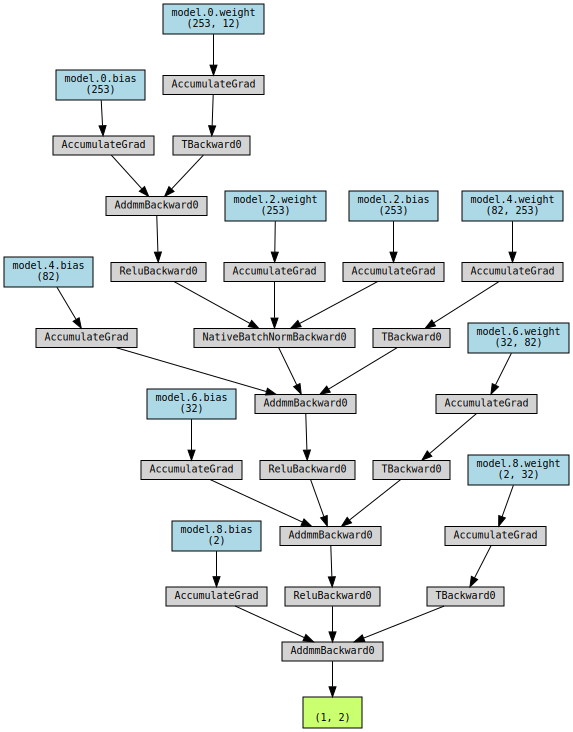

In [ ]:
from torchviz import make_dot
import torch

# Example input tensor
x = torch.randn(1, n_predictors)

# Forward pass
y = best_model(x)

# Plot the computation graph
dot = make_dot(y, params=dict(best_model.named_parameters()))
dot.render("neural_network", format="png")  # Save as PNG
dot